In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import random

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat_trainmode import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import editdistance

def compute_edit_distance(seqs, opt_len=None) :
    shuffle_index = np.arange(len(seqs))
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)
    
    seqs_shuffled = [seqs[shuffle_index[i]] for i in range(len(seqs))]
    edit_distances = np.ravel([float(editdistance.eval(seq_1, seq_2)) for seq_1, seq_2 in zip(seqs, seqs_shuffled)])
    if opt_len is not None :
        edit_distances /= opt_len
    
    return edit_distances


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_isoform_loss(target_isos, isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    entropy_anneal_coeff = K.variable(0.)
    entropy_anneal_func = lambda alpha, epoch: 1. # - 0.95 ** epoch
    
    target_iso = np.zeros((len(target_isos), 1))
    for i, t_iso in enumerate(target_isos) :
        target_iso[i, 0] = t_iso
    
    masked_use_entropy_mse = get_target_entropy_sme_masked(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    masked_dse_entropy_mse = get_target_entropy_sme_masked(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=70-60, pwm_end=76+60, margin=similarity_margin, shift_1_nt=True)
    
    extra_sim = np.ones((len(target_isos), 1, 205, 4, 1))
    for i in range(len(target_isos)) :
        extra_sim[i, 0, 70-4:76, :, 0] = 0.0
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_anneal_coeff * entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask), axis=1)
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    def val_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * symmetric_sigmoid_kl_divergence(iso_true, iso_pred)[:, 0, ...]
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * punish_dn_cse_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_c * punish_up_c_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_c * punish_dn_c_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_g * punish_up_g_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_g * punish_dn_g_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_aa * punish_up_aa_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_aa * punish_dn_aa_func(sampled_pwm_1)[:, 0, ...]
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_anneal_coeff * entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask)[:, 0, ...]
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    def val_loss_func_noentropy(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * symmetric_sigmoid_kl_divergence(iso_true, iso_pred)[:, 0, ...]
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * punish_dn_cse_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_c * punish_up_c_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_c * punish_dn_c_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_g * punish_up_g_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_g * punish_dn_g_func(sampled_pwm_1)[:, 0, ...]
        
        seq_loss += punish_up_aa * punish_up_aa_func(sampled_pwm_1)[:, 0, ...]
        seq_loss += punish_dn_aa * punish_dn_aa_func(sampled_pwm_1)[:, 0, ...]
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = similarity_weight * pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask)[:, 0, ...]
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    def val_loss_func_onlyisoform(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        #iso_loss = 2.0 * symmetric_sigmoid_kl_divergence(iso_true, iso_pred)[:, 0, ...]
        iso_loss = -1.0 * iso_score_pred
        
        #Compute total loss
        total_loss = iso_loss

        return total_loss
    
    return loss_func, val_loss_func, val_loss_func_noentropy, val_loss_func_onlyisoform, entropy_anneal_coeff, entropy_anneal_func


In [3]:

#Sequence optimization monitor during training
class GenesisMonitor(Callback):
    def __init__(self, generator_model, sequence_encoder, run_dir="", run_prefix="", val_steps=1, batch_size=32) :
        self.generator_model = generator_model
        self.batch_size = batch_size
        self.val_steps = val_steps
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        self.edit_distance_samples = []
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        self._store_sequences(seqs, 0)
        self._compute_edit_distances(seqs, 0)
    
    def _sample_sequences(self) :
        gen_bundle = self.generator_model.predict(x=None, steps=self.val_steps)
        _, _, _, _, _, sampled_pwm, _, _, _ = gen_bundle
        
        seqs = [
            self.sequence_encoder.decode(sampled_pwm[i, 0, :, :, 0]) for i in range(sampled_pwm.shape[0])
        ]
        
        return seqs
    
    def _compute_edit_distances(self, seqs, epoch) :
        
        edit_dists = compute_edit_distance(seqs)
        self.edit_distance_samples.append(edit_dists.reshape(1, -1))
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.val_steps) + "_steps.txt", "wt") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_epoch_end(self, epoch, logs={}) :
        
        seqs = self._sample_sequences()
        self._store_sequences(seqs, epoch)
        self._compute_edit_distances(seqs, epoch)

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps))
    
    def on_epoch_end(self, epoch, logs={}) :
        #Track val loss
        
        val_loss_values = self.val_loss_model.predict(x=None, steps=self.val_steps)
        
        self.val_loss_history.append(val_loss_values)
        
        print("mean(" + self.val_name + ") = " + str(np.mean(val_loss_values)))

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(run_prefix, sequence_templates, loss_funcs, library_contexts, batch_size=32, sample_mode='pwm', n_samples=1, n_epochs=10, steps_per_epoch=100, val_steps=100, normalize_logits=False) :
    
    loss_func, val_loss_func, val_loss_func_noentropy, val_loss_func_onlyisoform, entropy_anneal_coeff, entropy_anneal_func = loss_funcs
    
    if sample_mode == 'both' :
        return _run_both_genesis(run_prefix, sequence_templates, loss_funcs, library_contexts, batch_size, n_samples, n_epochs, steps_per_epoch, val_steps)
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=normalize_logits, validation_sample_mode='sample')

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode=sample_mode)
    _, val_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')
    for layer in val_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_valversion"

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(predictor, loss_func)
    
    _, val_loss_model = build_loss_model(val_predictor, val_loss_func)
    _, val_loss_noentropy_model = build_loss_model(val_predictor, val_loss_func_noentropy)
    _, val_loss_onlyisoform_model = build_loss_model(val_predictor, val_loss_func_onlyisoform)
    

    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    validation_history = ValidationCallback('val_loss', val_loss_model, val_steps)
    validation_noentropy_history = ValidationCallback('val_loss_no_entropy', val_loss_noentropy_model, val_steps)
    validation_onlyisoform_history = ValidationCallback('val_loss_only_isoform', val_loss_onlyisoform_model, val_steps)
    
    #Standard sequence decoder
    acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
    
    #Build callback for printing intermediate sequences
    genesis_monitor = GenesisMonitor(generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", val_steps=val_steps, batch_size=batch_size)
    
    #Specify callback entities
    callbacks =[
        EpochVariableCallback(entropy_anneal_coeff, entropy_anneal_func),
        validation_history,
        validation_noentropy_history,
        validation_onlyisoform_history,
        genesis_monitor
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )
    
    validation_history_dict = {
        'val_name' : validation_history.val_name,
        'val_loss_history' : validation_history.val_loss_history
    }
    validation_history.val_loss_model = None
    
    validation_noentropy_history_dict = {
        'val_name' : validation_noentropy_history.val_name,
        'val_loss_history' : validation_noentropy_history.val_loss_history
    }
    validation_noentropy_history.val_loss_model = None
    
    validation_onlyisoform_history_dict = {
        'val_name' : validation_onlyisoform_history.val_name,
        'val_loss_history' : validation_onlyisoform_history.val_loss_history
    }
    validation_onlyisoform_history.val_loss_model = None
    
    edit_distance_dict = {
        'edit_distance_samples' : genesis_monitor.edit_distance_samples
    }
    genesis_monitor.generator_model = None

    return generator, predictor, train_history, [validation_history_dict, validation_noentropy_history_dict, validation_onlyisoform_history_dict, edit_distance_dict]


def _run_both_genesis(run_prefix, sequence_templates, loss_funcs, library_contexts, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100, val_steps=100, normalize_logits=False) :
    
    loss_func, val_loss_func, val_loss_func_noentropy, val_loss_func_onlyisoform, entropy_anneal_coeff, entropy_anneal_func = loss_funcs
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=normalize_logits, validation_sample_mode='sample')

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')
    for layer in pwm_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_pwmversion"
    _, val_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')
    for layer in val_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_valversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    _, val_loss_model = build_loss_model(val_predictor, val_loss_func)
    _, val_loss_noentropy_model = build_loss_model(val_predictor, val_loss_func_noentropy)
    _, val_loss_onlyisoform_model = build_loss_model(val_predictor, val_loss_func_onlyisoform)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    validation_history = ValidationCallback('val_loss', val_loss_model, val_steps)
    validation_noentropy_history = ValidationCallback('val_loss_no_entropy', val_loss_noentropy_model, val_steps)
    validation_onlyisoform_history = ValidationCallback('val_loss_only_isoform', val_loss_onlyisoform_model, val_steps)
    
    #Standard sequence decoder
    acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
    
    #Build callback for printing intermediate sequences
    genesis_monitor = GenesisMonitor(generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", val_steps=val_steps, batch_size=batch_size)
    
    #Specify callback entities
    callbacks =[
        EpochVariableCallback(entropy_anneal_coeff, entropy_anneal_func),
        validation_history,
        validation_noentropy_history,
        validation_onlyisoform_history,
        genesis_monitor
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )

    validation_history_dict = {
        'val_name' : validation_history.val_name,
        'val_loss_history' : validation_history.val_loss_history
    }
    validation_history.val_loss_model = None
    
    validation_noentropy_history_dict = {
        'val_name' : validation_noentropy_history.val_name,
        'val_loss_history' : validation_noentropy_history.val_loss_history
    }
    validation_noentropy_history.val_loss_model = None
    
    validation_onlyisoform_history_dict = {
        'val_name' : validation_onlyisoform_history.val_name,
        'val_loss_history' : validation_onlyisoform_history.val_loss_history
    }
    validation_onlyisoform_history.val_loss_model = None
    
    edit_distance_dict = {
        'edit_distance_samples' : genesis_monitor.edit_distance_samples
    }
    genesis_monitor.generator_model = None

    return generator, sample_predictor, train_history, [validation_history_dict, validation_noentropy_history_dict, validation_onlyisoform_history_dict, edit_distance_dict]


In [4]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)

In [5]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple'
]

target_isos = [
    1.0
]



In [6]:
def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

In [ ]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS (Max Isoform)")

#Sampling conditions to evaluate
sampling_conds = [
    ['pwm', 1, False],
    ['sample', 1, False],
    ['sample', 10, False],
    ['both', 1, False],
    ['both', 10, False]
]

#Number of PWMs to generate per objective
batch_size = 32

#Number of epochs per objective to optimize
n_epochs = 100

#Number of steps (grad updates) per epoch
steps_per_epoch = 50

#Number of validation steps
val_steps = 50

#Number of independent trial runs
n_runs = 5

seeds = [51125, 222842, 325484, 475737, 727322]

for sampling_cond_ix, sampling_cond in enumerate(sampling_conds) :
    print("Sampling mode = '" + str(sampling_cond[0]) + "', n_samples = '" + str(sampling_cond[1]) + "'")

    if len(sampling_cond) <= 3 :
    
        sampling_dict = {'train' : [], 'val' : []}
        sampling_cond.append(sampling_dict)

        for run_ix in range(n_runs) :

            K.clear_session()

            set_seed(seeds[run_ix])

            losses = get_isoform_loss(
                target_isos,
                use_start=22,
                use_end=70,
                use_target_bits=1.95,
                cse_start=70,
                cse_end=76,
                cse_target_bits=1.95,
                dse_start=76,
                dse_end=121,
                dse_target_bits=1.95,
                entropy_weight=0.0,
                similarity_weight=5.0,
                similarity_margin=0.5,
                punish_dn_cse=1.0,
                punish_up_c=0.0015,
                punish_dn_c=0.0001,
                punish_up_g=0.0001,
                punish_dn_g=0.0001,
                punish_up_aa=0.00025,
                punish_dn_aa=0.005
            )
            
            run_prefix = "genesis_apa_max_isoform_simple_eval_sampling_modes_no_entropy_penalty_longtrain_cond_" + str(sampling_cond_ix) + "_run_" + str(run_ix)

            genesis_generator, genesis_predictor, train_history, validation_histories = run_genesis(run_prefix, sequence_templates, losses, library_contexts, batch_size, sampling_cond[0], sampling_cond[1], n_epochs, steps_per_epoch, val_steps, sampling_cond[2])

            sampling_dict['train'].append(train_history.history)
            sampling_dict['val'].append(validation_histories)


In [8]:
#Store generated results

experiment_name = "apa_max_isoform_eval_sampling_modes_no_entropy_penalty_longtrain_results_" + str(len(seeds)) + "_seeds"

pickle.dump({ 'sampling_conds' : sampling_conds }, open(experiment_name + ".pickle", 'wb'))


In [7]:
#Load cached results

n_epochs = 100
n_runs = 5

experiment_name = "apa_max_isoform_eval_sampling_modes_no_entropy_penalty_longtrain_results_" + str(n_runs) + "_seeds"

sampling_conds = pickle.load(open(experiment_name + ".pickle", 'rb'))['sampling_conds']


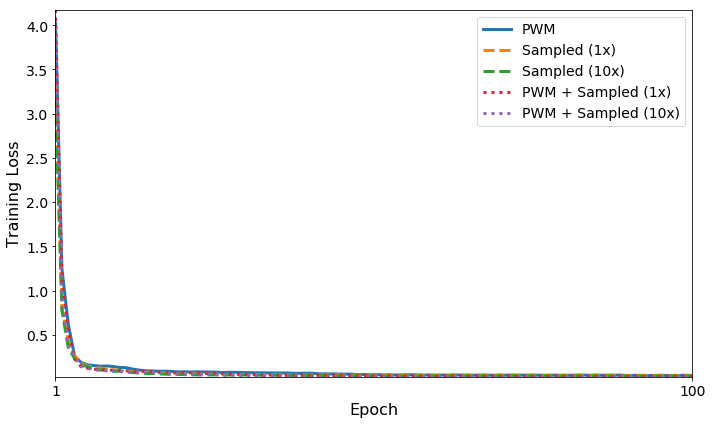

In [8]:

f = plt.figure(figsize=(10, 6))

summary_mode = 'median'
fig_suffix = "_" + str(n_epochs) + '_epochs_no_entropy_eval_pwm_vs_sample'

ls = []

min_y = 10000
max_y = 0

save_figs = True

for sampling_cond in sampling_conds :
    
    norm_prefix = ''
    if sampling_cond[2] == True :
        norm_prefix = '-IN'

    label = 'PWM' + norm_prefix
    linestyle = '-'
    if sampling_cond[0] == 'sample' :
        label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = '--'
    elif sampling_cond[0] == 'both' :
        label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = ':'
    
    train_hists = np.concatenate([np.array(sampling_cond[3]['train'][i]['loss']).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
    mean_train_hist = np.mean(train_hists, axis=-1) if summary_mode == 'mean' else np.median(train_hists, axis=-1)
                                                                                                
    l1 = plt.plot(np.arange(mean_train_hist.shape[0]), mean_train_hist, linewidth=3, linestyle=linestyle, label=label)
    ls.append(l1[0])
    
    if np.max(mean_train_hist) > max_y :
        max_y = np.max(mean_train_hist)
    
    if np.min(mean_train_hist) < min_y :
        min_y = np.min(mean_train_hist)

plt.xlim(0, n_epochs-1)
plt.xticks([0, n_epochs-1], [1, n_epochs], fontsize=14)

plt.ylim(min_y, max_y)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Training Loss", fontsize=16)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_training_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_training_' + summary_mode + fig_suffix + '.eps')
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_training_' + summary_mode + fig_suffix + '.svg')

plt.show()


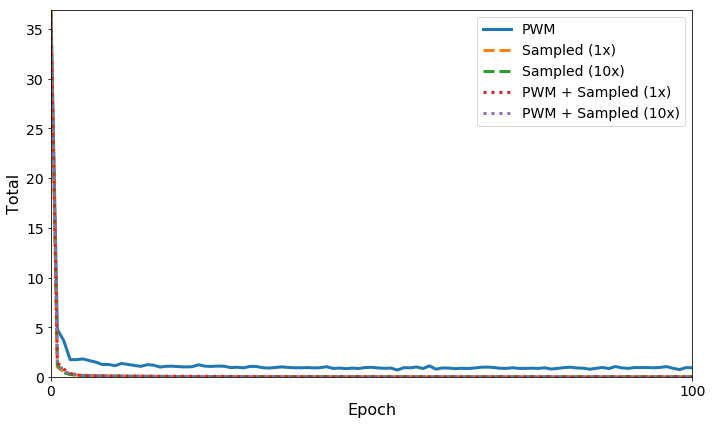

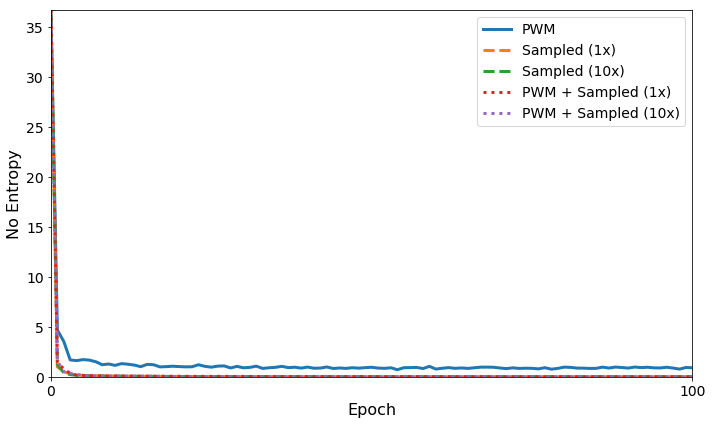

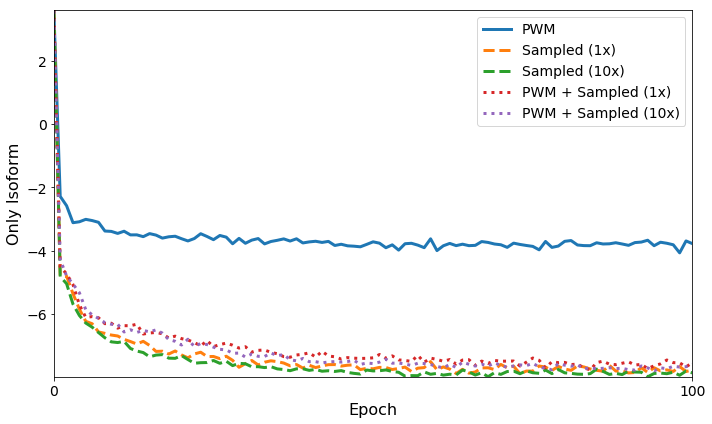

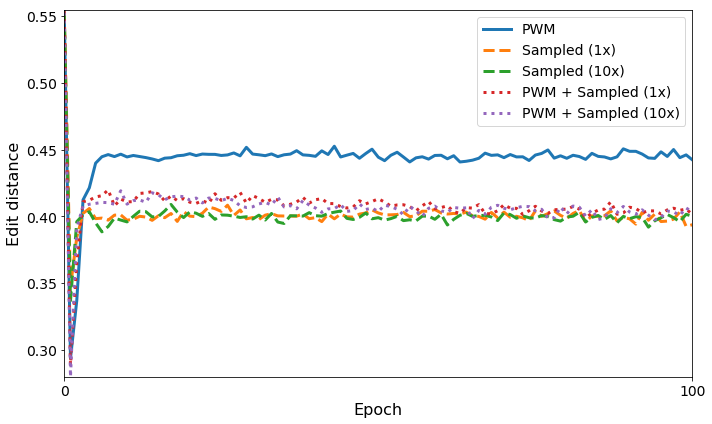

In [9]:

start_from_epoch = 0

summary_mode = 'median'
fig_suffix = "_" + str(n_epochs) + '_epochs_no_entropy_eval_pwm_vs_sample_from_epoch_' + str(start_from_epoch)

save_figs = True

for val_ix, val_name in enumerate(['Total', 'No Entropy', 'Only Isoform']) :

    f = plt.figure(figsize=(10, 6))

    ls = []

    min_y = 10000
    max_y = -10000

    for sampling_cond in sampling_conds :

        val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][val_ix]['val_loss_history'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
        mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)

        norm_prefix = ''
        if sampling_cond[2] == True :
            norm_prefix = '-IN'
        
        label = 'PWM' + norm_prefix
        linestyle = '-'
        if sampling_cond[0] == 'sample' :
            label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = '--'
        elif sampling_cond[0] == 'both' :
            label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = ':'

        l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
        ls.append(l1[0])

        if np.max(mean_val_hist[start_from_epoch:]) > max_y :
            max_y = np.max(mean_val_hist[start_from_epoch:])
        
        if np.min(mean_val_hist[start_from_epoch:]) < min_y :
            min_y = np.min(mean_val_hist[start_from_epoch:])

    plt.xlim(start_from_epoch, n_epochs)
    plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

    plt.ylim(min_y, max_y)
    plt.yticks(fontsize=14)

    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(val_name, fontsize=16)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()
    
    if save_figs :
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.eps')
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.svg')
    
    plt.show()


#Plot edit distance curves

opt_len = 90

f = plt.figure(figsize=(10, 6))

ls = []

min_y = 10000
max_y = -10000

for sampling_cond in sampling_conds :

    val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][3]['edit_distance_samples'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
    mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)
    if opt_len is not None :
        mean_val_hist /= opt_len
    
    norm_prefix = ''
    if sampling_cond[2] == True :
        norm_prefix = '-IN'

    label = 'PWM' + norm_prefix
    linestyle = '-'
    if sampling_cond[0] == 'sample' :
        label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = '--'
    elif sampling_cond[0] == 'both' :
        label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = ':'

    l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
    ls.append(l1[0])

    if np.max(mean_val_hist[start_from_epoch:]) > max_y :
        max_y = np.max(mean_val_hist[start_from_epoch:])

    if np.min(mean_val_hist[start_from_epoch:]) < min_y :
        min_y = np.min(mean_val_hist[start_from_epoch:])

plt.xlim(start_from_epoch, n_epochs)
plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

plt.ylim(min_y, max_y)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Edit distance", fontsize=16)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.eps')
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.svg')

plt.show()


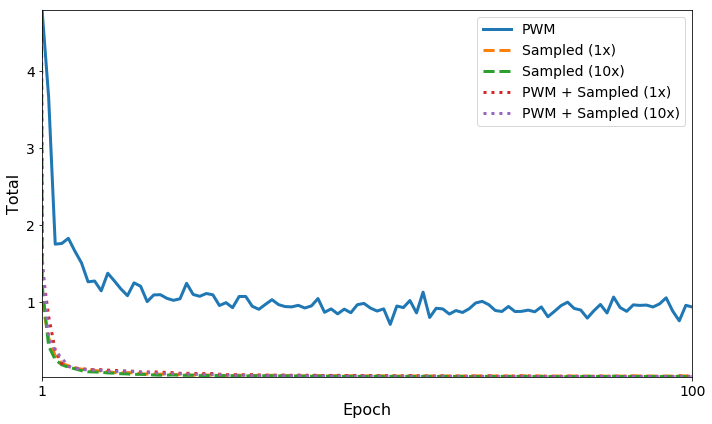

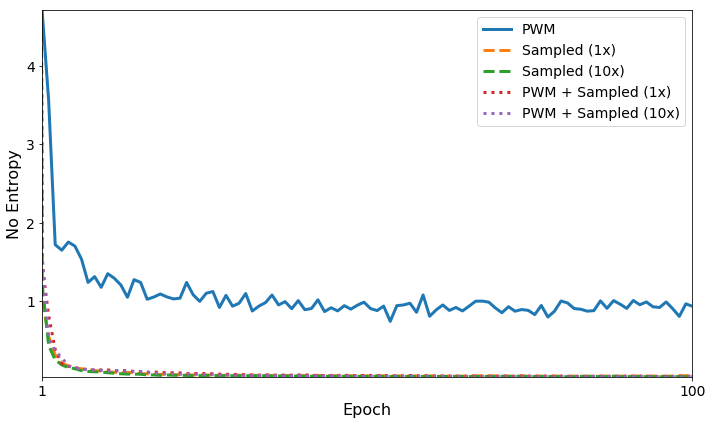

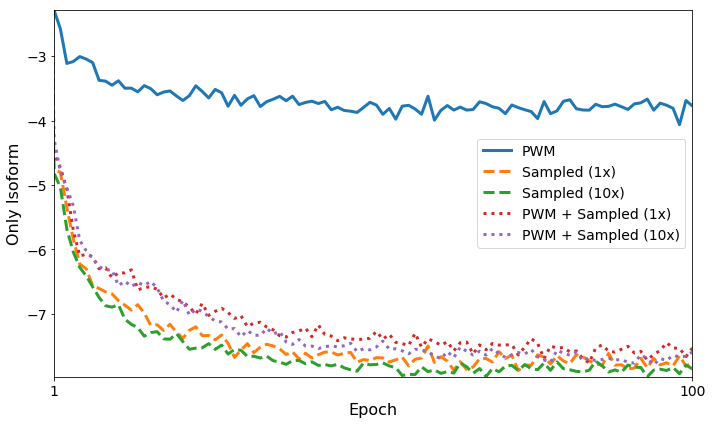

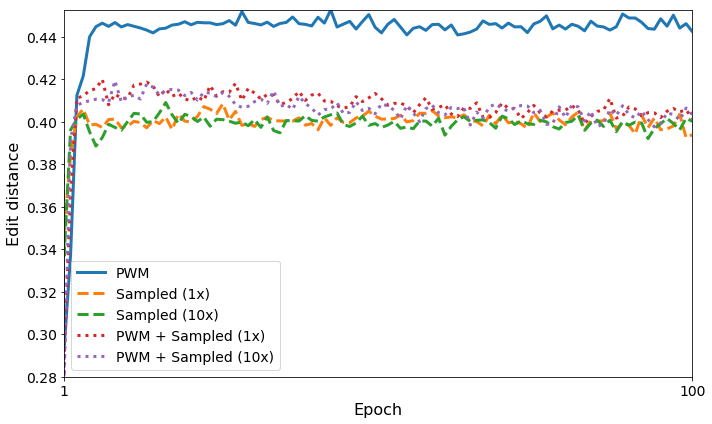

In [10]:

start_from_epoch = 1

summary_mode = 'median'
fig_suffix = "_" + str(n_epochs) + '_epochs_no_entropy_eval_pwm_vs_sample_from_epoch_' + str(start_from_epoch)

save_figs = True

for val_ix, val_name in enumerate(['Total', 'No Entropy', 'Only Isoform']) :

    f = plt.figure(figsize=(10, 6))

    ls = []

    min_y = 10000
    max_y = -10000

    for sampling_cond in sampling_conds :

        val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][val_ix]['val_loss_history'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
        mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)

        norm_prefix = ''
        if sampling_cond[2] == True :
            norm_prefix = '-IN'
        
        label = 'PWM' + norm_prefix
        linestyle = '-'
        if sampling_cond[0] == 'sample' :
            label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = '--'
        elif sampling_cond[0] == 'both' :
            label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = ':'

        l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
        ls.append(l1[0])

        if np.max(mean_val_hist[start_from_epoch:]) > max_y :
            max_y = np.max(mean_val_hist[start_from_epoch:])
        
        if np.min(mean_val_hist[start_from_epoch:]) < min_y :
            min_y = np.min(mean_val_hist[start_from_epoch:])

    plt.xlim(start_from_epoch, n_epochs)
    plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

    plt.ylim(min_y, max_y)
    plt.yticks(fontsize=14)

    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(val_name, fontsize=16)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()
    
    if save_figs :
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.eps')
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.svg')
    
    plt.show()


#Plot edit distance curves

opt_len = 90

f = plt.figure(figsize=(10, 6))

ls = []

min_y = 10000
max_y = -10000

for sampling_cond in sampling_conds :

    val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][3]['edit_distance_samples'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
    mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)
    if opt_len is not None :
        mean_val_hist /= opt_len
    
    norm_prefix = ''
    if sampling_cond[2] == True :
        norm_prefix = '-IN'

    label = 'PWM' + norm_prefix
    linestyle = '-'
    if sampling_cond[0] == 'sample' :
        label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = '--'
    elif sampling_cond[0] == 'both' :
        label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = ':'

    l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
    ls.append(l1[0])

    if np.max(mean_val_hist[start_from_epoch:]) > max_y :
        max_y = np.max(mean_val_hist[start_from_epoch:])

    if np.min(mean_val_hist[start_from_epoch:]) < min_y :
        min_y = np.min(mean_val_hist[start_from_epoch:])

plt.xlim(start_from_epoch, n_epochs)
plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

plt.ylim(min_y, max_y)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Edit distance", fontsize=16)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.eps')
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.svg')

plt.show()


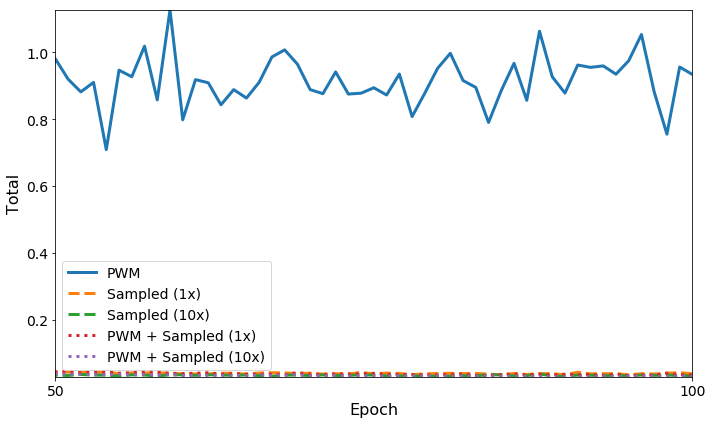

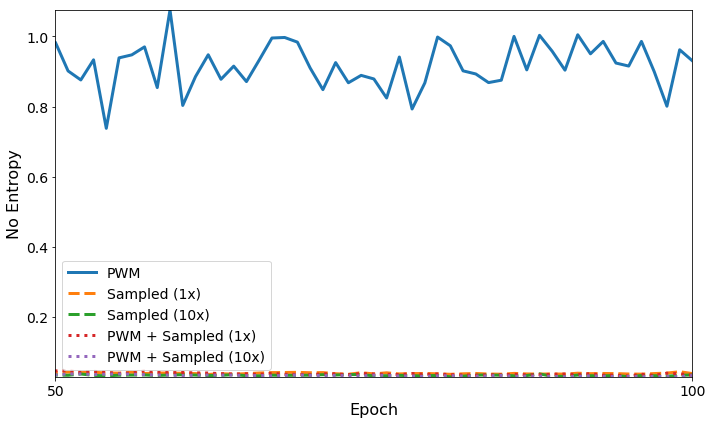

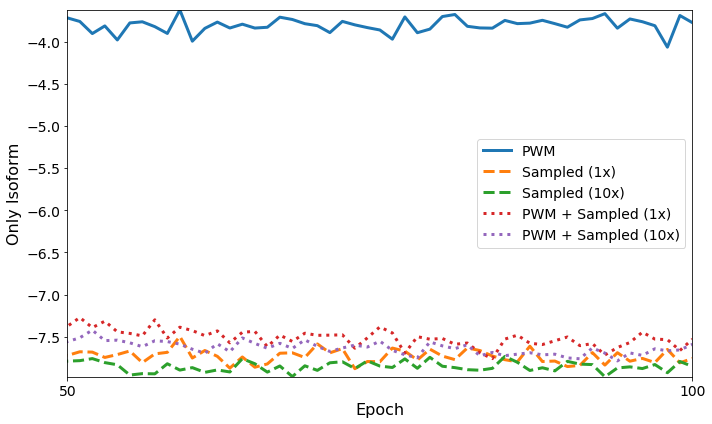

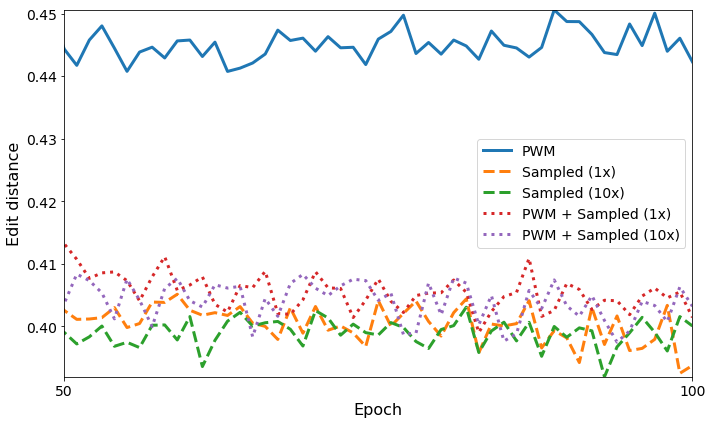

In [11]:

start_from_epoch = 50

summary_mode = 'median'
fig_suffix = "_" + str(n_epochs) + '_epochs_no_entropy_eval_pwm_vs_sample_from_epoch_' + str(start_from_epoch)

save_figs = True

for val_ix, val_name in enumerate(['Total', 'No Entropy', 'Only Isoform']) :

    f = plt.figure(figsize=(10, 6))

    ls = []

    min_y = 10000
    max_y = -10000

    for sampling_cond in sampling_conds :

        val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][val_ix]['val_loss_history'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
        mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)

        norm_prefix = ''
        if sampling_cond[2] == True :
            norm_prefix = '-IN'
        
        label = 'PWM' + norm_prefix
        linestyle = '-'
        if sampling_cond[0] == 'sample' :
            label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = '--'
        elif sampling_cond[0] == 'both' :
            label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
            linestyle = ':'

        l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
        ls.append(l1[0])

        if np.max(mean_val_hist[start_from_epoch:]) > max_y :
            max_y = np.max(mean_val_hist[start_from_epoch:])
        
        if np.min(mean_val_hist[start_from_epoch:]) < min_y :
            min_y = np.min(mean_val_hist[start_from_epoch:])

    plt.xlim(start_from_epoch, n_epochs)
    plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

    plt.ylim(min_y, max_y)
    plt.yticks(fontsize=14)

    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(val_name, fontsize=16)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()
    
    if save_figs :
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.eps')
        plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_' + str(val_ix) + '_' + summary_mode + fig_suffix + '.svg')
    
    plt.show()


#Plot edit distance curves

opt_len = 90

f = plt.figure(figsize=(10, 6))

ls = []

min_y = 10000
max_y = -10000

for sampling_cond in sampling_conds :

    val_hists = np.concatenate([np.array([np.mean(sampling_cond[3]['val'][i][3]['edit_distance_samples'][j]) for j in range(n_epochs + 1)] ).reshape(-1, 1) for i in range(len(np.array(sampling_cond[3]['train'])))], axis=1)
    mean_val_hist = np.mean(val_hists, axis=-1) if summary_mode == 'mean' else np.median(val_hists, axis=-1)
    if opt_len is not None :
        mean_val_hist /= opt_len
    
    norm_prefix = ''
    if sampling_cond[2] == True :
        norm_prefix = '-IN'

    label = 'PWM' + norm_prefix
    linestyle = '-'
    if sampling_cond[0] == 'sample' :
        label = "Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = '--'
    elif sampling_cond[0] == 'both' :
        label = "PWM" + norm_prefix + " + Sampled" + norm_prefix + " (" + str(sampling_cond[1]) + "x)"
        linestyle = ':'

    l1 = plt.plot(np.arange(mean_val_hist.shape[0]), mean_val_hist, linewidth=3, linestyle=linestyle, label=label)
    ls.append(l1[0])

    if np.max(mean_val_hist[start_from_epoch:]) > max_y :
        max_y = np.max(mean_val_hist[start_from_epoch:])

    if np.min(mean_val_hist[start_from_epoch:]) < min_y :
        min_y = np.min(mean_val_hist[start_from_epoch:])

plt.xlim(start_from_epoch, n_epochs)
plt.xticks([start_from_epoch, n_epochs], [start_from_epoch, n_epochs], fontsize=14)

plt.ylim(min_y, max_y)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Edit distance", fontsize=16)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.eps')
    plt.savefig('apa_genesis_max_isoform_learning_loss_curves_validation_edit_distance_' + summary_mode + fig_suffix + '.svg')

plt.show()
